# Aquaseca basic domain
## Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 
#### ET: 
- Zero in left half
- 1E-5 m/day in the right half of the domain
- Riparian zone
    - Extends from left to right boundary of rows 23 to 29, inclusive
    - Rate: 5E-5m/d
- Extinction depth= 10m
 
#### Recharge: 
 - Leftmost 15 columns at a rate of 4E-5 m/d
 - Zero everywhere else

#### Stream:
- Begins in left boundary and goes to the right in row 26
- width=length=thickness= 1.0
- No flow is entering the stream
- streambed
    - K= 1000m/d
    - elevation= 1.0m below ground surface
    - stage= 0.5m
- "weak sink" with strength 0.5 (This is set under MODPATH/Particle Options.)
 
#### Well: 
 - Pumping well for Aquaseca
     - Completed in bottom layer
     - Located at row 21, column 38
     - Pumping at a rate of 1500 m^3/day 

## Model Description after GroMore proposal 

#### Ag field:
- cover a 2000m by 2000m area
- 1/8th of the area will be irrigated agriculture at any time (the field area is multiplied by 0.125). 
- Rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).

##### ET
- ET for the crop is zero - it is accounted for in the calculated recharge 

##### Recharge
- Rate is 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization
- Crop water uses/recharge rates:
    - Wheat= 0.004m/d / 0.0001m/d
    - Pistachios= 0.006m/d / 0.00015m/d
    - Cotton: 0.008 m/d / 0.0002 m/d
    
##### Pumping Well:
- Completed in top layer
- Row 12 and column 14
- Pumping rate equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency
    - Wheat= 3000 m3/day
    - Pistachos= 4500 m3/d
    - Cotton= 6000 m3/d
    
##### Monitoring wells
- Two monitoring in transient conditions
    - One at [25000, 25000] 
    - Other at [12500, 12500].

*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [2]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os
import csv
import seaborn as sns
from pyDOE import *

#additional analysis tools
import flopy.utils.binaryfile as bf
from flopy.utils.sfroutputfile import SfrFile

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
np.set_printoptions(threshold=np.inf)


moddir="C:/WRDAPP/MF2005.1_12/bin/mf2005.exe"
modws ="C:/Users/davem/Documents/Thesis/modflow/mfoutput"
modws = "D:/mfoutput"

#jupyter specific--included to show plots in notebook
%matplotlib inline 

Parameter Values

K1, K2, and K3 = [5, 25, 100] # baseline Kx=Ky=Kz value in all zones (m/day)

Kz ratio_lowK = [1e-6, 1e-2, 1] # ratio of Kz in low-K layer to baseline K (-)

Sy = [0.05, 0.1, 0.3] # specific yield (-)

R_mountains = [1e-5, 3e-5, 5e-5] # recharge rate in mountains (m/day)

ET_valley = [1e-6, 1e-5, 1e-4] # ET rate in valley (m/day)

ETratio_riparian = [1, 2, 3] # ratio of ET in riparian area to ET rate in valley (m/day)

Kratio_streambed = [1e-2,1e-1, 1] # ratio of K in streambed to baseline K (-)

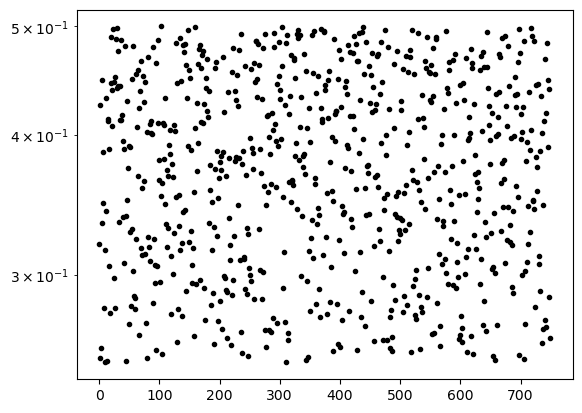

0.4999088177915265
0.25032583997867214


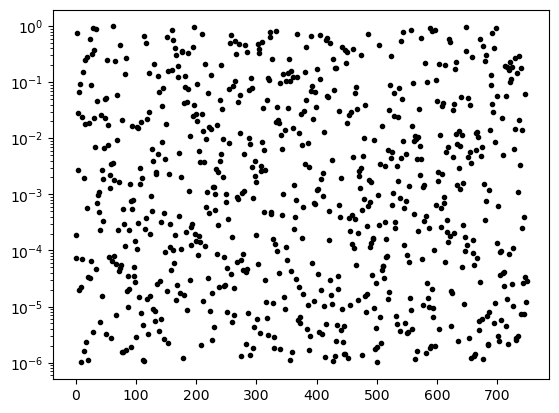

0.985152643507884
1.006799387625662e-06


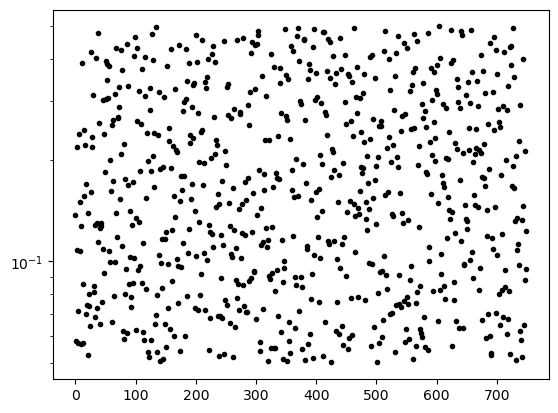

0.49967190353103264
0.050066207137222055


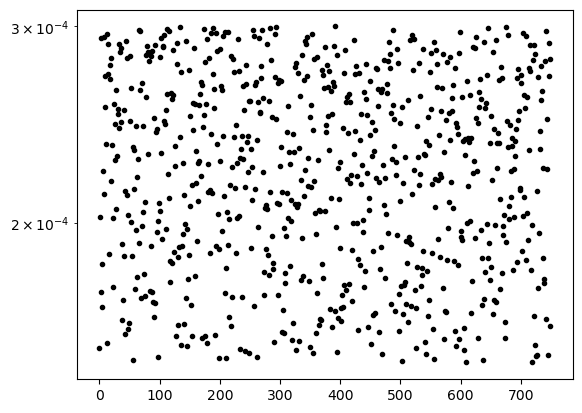

0.0002999605833806792
0.00015010170628195664


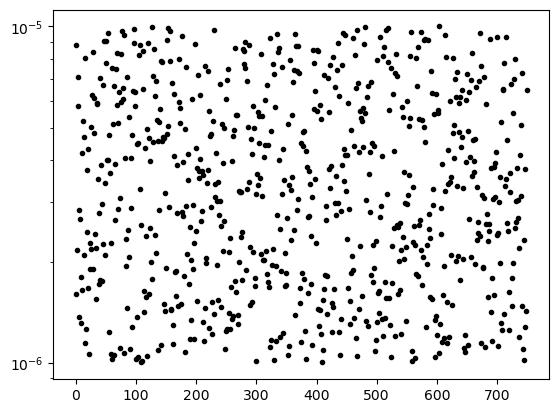

9.999641226502716e-06
1.0016765662557544e-06


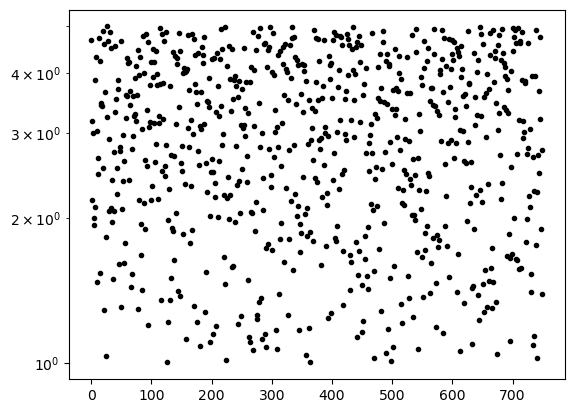

4.996376248354983
1.0033110529031926


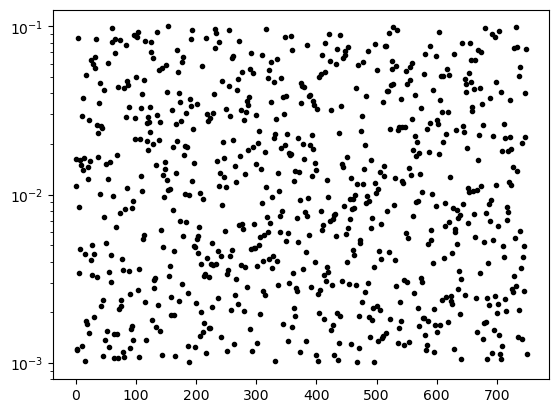

0.0999101984886784
0.0010059129734698816


In [2]:
#Set up parameter for ensemble
# K_h = [2, 50]       #was 5 to 100                                                                                                                      # base case retardation
# Kz_ratio = [0.001, 1]     
# Ka = [5, 100] #streambed K
# Sy = [0.05,0.3]                                                                                                                         
# R_mtn = [0.00003,0.00005]  #set 2e-5 as minimum for convergence
# ET_val = [0.0001,0.000001]   
# ET_ratio_rip = [1,3]
# krs = [0.0001, 0.005]


#Set up parameter for ensemble
K_h = [0.25, 0.5]#[0.15, 0.25] #[0.1,0.25]  #K_h = [0.001, 0.1]     #hone in on this one perhaps use 0.05                                                                                                                        
Kz_ratio = [0.000001, 1]                                                                                                                   
Sy = [0.05,0.5] #Sy = [0.05,0.5]                                                                                                                            
R_mtn = [0.00015,0.0003]  #set 2e-5 as minimum for convergence
ET_val = [0.000001,0.00001]   
ET_ratio_rip = [1,5]
Krs = [0.001, 0.1]#krs = [0.00001, 0.01] # it won't converge nicely with anything higher than 0.1
#Anis = [0.01, 1] # anistrophy! - not used below


num = 750

#latin hyper cube sampling
sampling = lhs(7, samples = num)
#print(sampling)
params = np.array([K_h, Kz_ratio, Sy, R_mtn, ET_val, ET_ratio_rip, Krs])
for i in range(7):
    if((params[i][1]/params[i][0]) >= 10):
        #log
        sampling[:,i] = 10**(np.log10(params[i][0]) + (np.log10(params[i][1]) - np.log10(params[i][0]))*sampling[:,i])
    else:
        #Linear 
        sampling[:,i] = params[i][0] + (params[i][1] - params[i][0])*sampling[:,i]
    
for i in range(7):
    plt.plot(sampling[:,i], 'k.')
    plt.yscale('log')
    plt.show()
    print(np.max(sampling[:,i]))
    print(np.min(sampling[:,i]))
    
    
#np.savetxt("ModflowParams7-750Test12.txt", sampling)

## 2. Discretization and other inputs

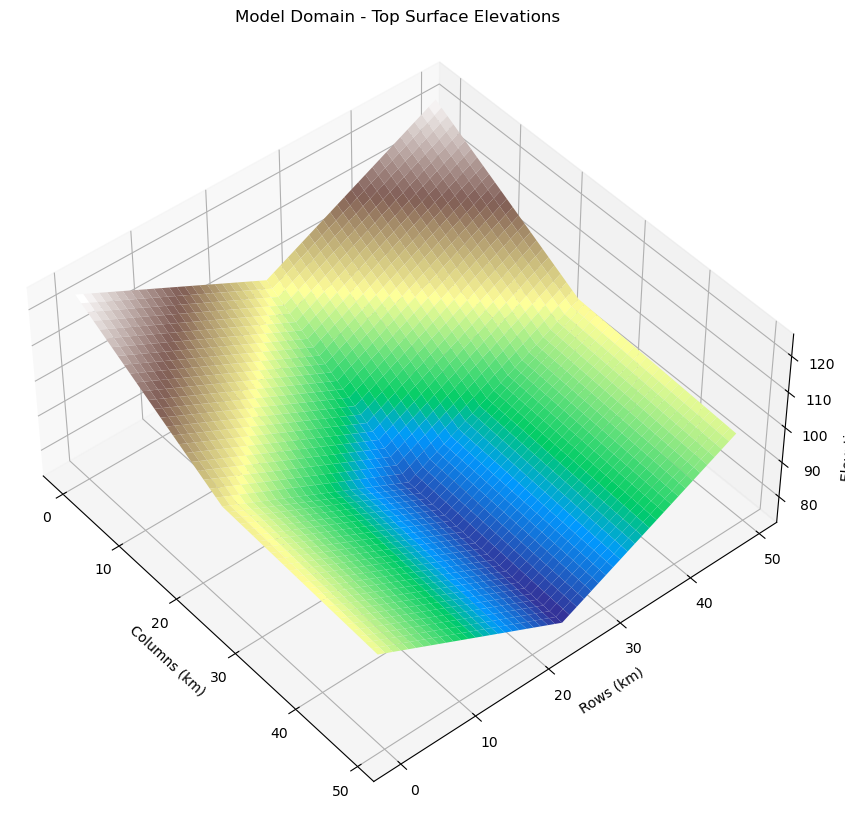

In [41]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

width = 100
dx= width #width of grid cells in x direction 
dy= width #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

#ztop = 100
ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)

## Subsurface properties
#K_horiz = 1.    #horizontal hydraulic conductivity 
#K_vert = 1.    #assign vertical hydraulic conductivity (along z axis)
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET = 1e-5 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
rip_ET= 10e-5  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
extinction_depth = 10 #m

ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (25.0, 49.0)

ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 


rip_rows_forced = (22.0, 29.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)

ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 

Rip_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
Rip_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 
## Recharge
rech=5e-5  #m/d


rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 20 cols
rech_cols_forced = (1.0, 10.0)

rech_zone_forced = np.zeros((1,nrow,ncol))
rech_zone_forced[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech

## Boundary conditions
h_right = 62 #was 70


## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

#Aqua Seca Well well
pumping = -450 #m3/day 
well_row =   19 #12
well_col =   32 #14
#well_loc = (2,well_row, well_col)
#well = [2,well_row, well_col, pumping] 

wel_spd =  {0: [2,well_row, well_col, pumping]}
#well_val = np.tile([1,0],sim_years+1)
# for p in range(1, nper):   
#     #pumping = 0
#     wel_spd[p] =  [2,well_row, well_col, pumping*well_val[p]]

# print(wel_spd)
#print(ztop)


### Layering

In [4]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 


## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array

## Make some changes to the parameters
bot_elev = 0. #0
mid_elev = 40. #40
top_elev = 45. #45

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 


## Boundary Conditions

In [5]:
#original BCS

#print(ibound)
#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value
#########################
#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,0,49]=0
ibound[:,49,49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

#new bottom no flow zone constriction
ibound[:,1,19:]=0
ibound[:,2,25:]=0
ibound[:,3,30:]=0
ibound[:,4,33:]=0
ibound[:,5,36:]=0
ibound[:,6,39:]=0
ibound[:,7,41:]=0
ibound[:,8,43:]=0
ibound[:,9,45:]=0
ibound[:,10,46:]=0
ibound[:,11,47:]=0
ibound[:,12,48:]=0

ibound[:,48,19:]=0
ibound[:,47,25:]=0
ibound[:,46,30:]=0
ibound[:,45,33:]=0
ibound[:,44,36:]=0
ibound[:,43,39:]=0
ibound[:,42,41:]=0
ibound[:,41,43:]=0
ibound[:,40,45:]=0
ibound[:,39,46:]=0
ibound[:,38,47:]=0
ibound[:,37,48:]=0

#np.savetxt("ibound_lyr1.txt", ibound[0])

## Stream

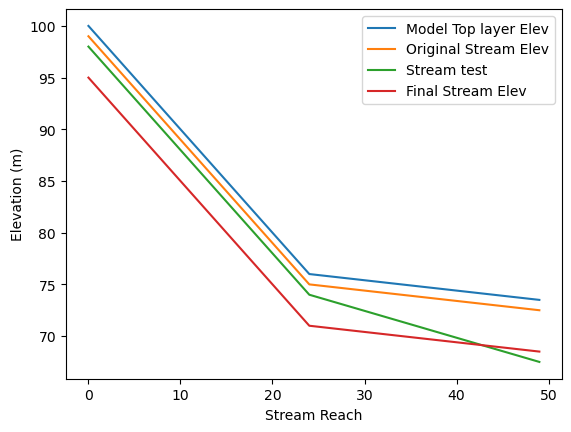

In [6]:
#SFR package inputs

reach = np.recarray((nrow,), dtype=[('k', '<f8'), ('i', '<f8'), ('j', '<f8'), ('iseg', '<f8'), ('ireach', '<f8'), ('rchlen', '<f8'),('strtop', '<f4')])

reach[:][:] = 0 # zero it out
reach['k'][:] = 0
reach['i'][:] = int(ncol/2)  #set it to the middle row
reach['j'][:] = [i for i in range(nrow)] #all columns in the middle row
reach['iseg'][:] = 1 #segment number - we only have 1 so all cells - segment number starts with 1!
#reach['iseg'][25:] = 2
reach['ireach'][:50] = [i for i in range(1,51)] #number the 50 reaches - starts with 1!
#reach['ireach'][25:] = [i for i in range(1,26)]
reach['rchlen'][:] = dx

str_elevs = np.linspace(ztop[25][0],ztop[25][-1],50) - 5#ztop[25] #[i for i in ztop[25]] #This was necessary in Transient but not in SS - otherwise it sets the stream elevation to 0 - not sure whyyy

reach['strtop'][:] = ztop[25] - 5 #+ (ztop[25] - str_elevs)*0.5 - 5

#print(reach)
dtype = flopy.modflow.ModflowSfr2.get_default_segment_dtype()
indices = ['nseg','width1','width2','icalc','roughch','flow','outseg','iupseg','hcond1','hcond2','thickm1','thickm2','etsw','pptsw','elevup','elevdn']
#print(dtype)
#print(dtype[indices])
seg_data = np.recarray((1,), dtype[indices])
seg_data[:] = 0
seg_data['width1'] = 5 #2
seg_data['width2'] = 10 #2
seg_data['icalc'] = 1
seg_data['nseg'] = 1
seg_data['roughch'] = 0.035
seg_data['flow'] = 0
seg_data['hcond1'] = 0.0001
seg_data['hcond2'] = 0.0001
seg_data['thickm1'] = 2
seg_data['thickm2'] = 2
#seg_data['elevup'] = 100
#seg_data['elevdn'] = 70
seg_data['etsw'] = 0
seg_data['pptsw'] = 0
seg_data['elevup'] = reach['strtop'][0]   #elevation at start added reach strtop for transeint was 100 and 70 for eleveldn
seg_data['elevdn'] = reach['strtop'][-1]
segment_data = seg_data

nstrm = len(reach)  # number of reaches
nss = 1 #len(seg_data[0])  # number of segments
nsfrpar = 0  # number of parameters (not supported)
nparseg = 0
const = 1 #turns out were in meters and days so according to flopy this should be 1 for meters x 86400 for days   # constant for manning's equation, units of cfs
dleak = 0.01 # 0.0001  # closure tolerance for stream stage computation
ipakcb = 53  # flag for writing SFR output to cell-by-cell budget (on unit 53)
istcb2 = 81  # flag for writing SFR output to text file
dataset_5 = {0: [nss, 0, 0]}  # dataset 5 (see online guide)

str_elevs = np.linspace(ztop[25][24]-2,ztop[25][-1]-6,26)
streamtest = []
streamtest = ztop[25] -2
streamtest[24:] = str_elevs

plt.plot(ztop[25], label='Model Top layer Elev')
plt.plot(ztop[25]-1, label='Original Stream Elev')
plt.plot(streamtest, label='Stream test')
plt.plot(reach['strtop'][:], label = 'Final Stream Elev')
plt.xlabel('Stream Reach')
plt.ylabel('Elevation (m)')
plt.legend()

## create packages and run model

In [ ]:
#create model object

sampling = np.loadtxt("ModflowParams7-750Test12.txt")

error_list = []

num = len(sampling)
#num = 100
leakage_array = np.zeros((num,1))


for i in range(num):
    #print(sampling[i])
    modelname = "ScenarioSfrWell750Test3_"+str(i)
    m = flopy.modflow.Modflow(modelname,model_ws = modws, exe_name = moddir)

    #Discretization - dis
    dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

    # Boundary and initial conditions - bas
    bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

    #Layer properties - lpf
    ## make horizontal K np arrays
    #Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
    Kh[:,:,:] = sampling[i][0] # assign the original value to the entire array

    ## Make a arrays for the K values
    #Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
    Kz[:,:,:] = sampling[i][0] #* sampling[i][7]                # assign the original value to the entire array
    
    #restrictive layer
    Kz[1,:,10:49] = sampling[i][0] * sampling[i][1] #* sampling[i][7]       #Replace K in the middle layer with the lower value
    Kh[1,:,10:49] = sampling[i][0] * sampling[i][1] 
    
    #changed to 10 for start of restrictive layer
    Sy = sampling[i][2]
    
    lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, #laywet = [1,1,1],
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)
    #ET - evt
    ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = sampling[i][4]
    ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = (sampling[i][4] * sampling[i][5])
   
    evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 

    #Recharge - rch
    rech_zone_forced[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=sampling[i][3]
   

   
    rch = flopy.modflow.mfrch.ModflowRch(model=m, nrchop=3, rech=rech_zone_forced, ipakcb=53)     #create rch object

    seg_data['hcond1'] = sampling[i][6] 
    seg_data['hcond2'] = sampling[i][6]
    
    sfr = flopy.modflow.ModflowSfr2(
        model = m,
        nstrm=nstrm,
        nss=nss,
        const=const,
        dleak=dleak,
        ipakcb=ipakcb,
        #istcb1 = 81,
        istcb2=istcb2,
        reach_data=reach,
        segment_data=seg_data,
        #channel_geometry_data=channel_geometry_data,
        #channel_flow_data=channel_flow_data,
        dataset_5=dataset_5,
        #unit_number=15,
    )
    
    
    #Well - wel
    wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

    #Output control - OC 
    spd = {(-1, -1): [],
        (0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
    oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

    #Numerical solver - pcg
    pcg = flopy.modflow.ModflowPcg(model=m, 
                               mxiter=100, iter1=200, 
                               relax = 0.97
                               # damp = 0.7
                              )
   # chk = sfr.check()
#     wel.check()
#     pcg.check()
#     m.check()
#     oc.check()
#     evt.check()
#     rch.check()
#     lpf.check()
#     bas.check()
    #write the inputs
    #sfr.plot(key='iseg')
    m.write_input()   
    
    #Run the model 
    success, mfoutput = m.run_model(pause=False, report=True)
    if not success:
        #raise Exception('MODFLOW did not terminate normally.')      
        print('MODFLOW did not terminate normally. Parameters saved to file')
        #save parameters        
        error_list.append(np.hstack((np.array(i),sampling[i])))
        leakage_array[i] = -1
    else:  
        sfrout = SfrFile(modws+'/'+ modelname+'.sfr.out')
        df = sfrout.get_dataframe()
        leakage_array[i] = df.Qout[49]
#     budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')
#     #head = headobj.get_alldata(nodata=-9.9998999e+02)
#     leakage = budgobj.get_data(text='RIVER LEAKAGE')   
#     leakage_array[i] = sum(leakage[0][-10:].q)
 #     leakage_array[i] = sum(leakage[0][-10:].q)
if error_list:
    np.savetxt("ErrorSS_SfrWell750Test3.txt", error_list)
    print(len(error_list))

## Saving the output Q

In [16]:
#print(sfr.reach_data)

In [9]:
#print(leakage_array)
#print(sampling)
#sampling = np.loadtxt("ModflowParams7-1000_4.txt") 
if error_list:
    print('Last error list entry:')
    print(error_list[-1])
combined = np.hstack((sampling,leakage_array))
#print(len(combined))
if error_list:
    eidx = np.array(error_list)[:,0].astype(int)
    #print(eidx)
    error_free = np.delete(combined, eidx, axis=0)
else:
    error_free = combined
#print(error_free)
np.savetxt("ModflowSfrWellOutput750Test3.txt", error_free)

test = np.loadtxt("ModflowSfrWellOutput750Test3.txt")
#print(test)
# logpars = [0,1,4,6]
# for i in range(np.shape(test)[1] - 1):
#     plt.plot(test[:,i],test[:,-1], 'k.')
#     plt.yscale("log")
#     if i in logpars:
#         plt.xscale("log")
#     plt.show()
    

Last error list entry:
[7.36000000e+02 2.60552491e-01 2.91772467e-01 2.28295987e-01
 1.86207964e-04 1.18930567e-06 1.13866783e+00 5.06718830e-02]


C:\Users\davem\anaconda3\lib\site-packages\flopy\plot\crosssection.py:1693: MatplotlibDeprecationWarning: Passing the match_original parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patches = PatchCollection(rectcol, match_original, **kwargs)


NameError: name 'reach' is not defined

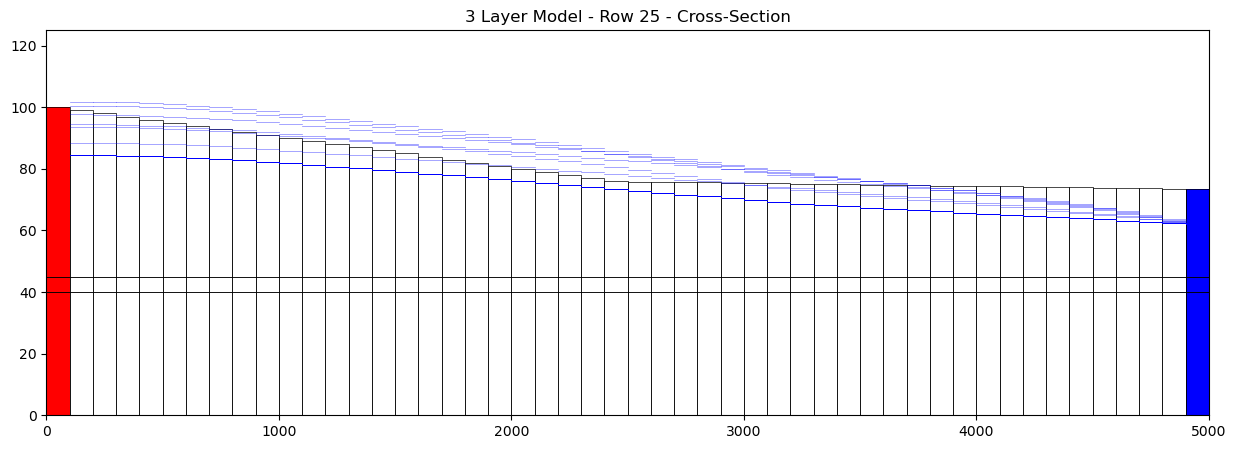

In [13]:
#temprange = np.arange(750)
#eidx = np.array(error_list)[:,0].astype(int)
#error_free = np.delete(temprange, eidx, axis=0)
mn = "D:/mfoutput/ScenarioSfrWell750_0.nam"
error_free = np.loadtxt("ModflowSfrWellOutput750Test3.txt")

m = flopy.modflow.Modflow.load(mn)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 25}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='green')
# t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')
#headpc = head[0]
#pc = xsect.plot_array(headpc,head=headpc, alpha=0.5)
#patches = xsect.plot_ibound(head=head[0][0])
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model - Row 25 - Cross-Section')
#cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
import random
rand_list = [int(error_free[i][-1]) for i in range(25,75)]
#rand_list = random.choice(error_free,size=25)
for i in rand_list: #rand_list[:100]:
    modelname = "ScenarioSfrWell750Test3_"+str(i)
    fname = modws+'/'+modelname+'.hds'
    hdobj = flopy.utils.HeadFile(fname)
    head = hdobj.get_data()
    wtup = xsect.plot_surface(head[0], lw=0.5, alpha=0.5)
    #wtlow = xsect.plot_surface(head[2], lw=0.5, alpha=0.5, color='purple')
plt.plot(np.arange(0,5000,100),reach['strtop'][:],color='green',linestyle='dashed', lw=1.5)
#plt.legend()
#print(rand_list)
#print(sampling[rand_list])
#print(head[0][0][1][:])

In [352]:
print(reach['strtop'][25])

67.9


In [177]:
low = np.where(test[:,-2] < 0.00005)
test = test[low]
for i in range(np.shape(test)[1] - 1):
    print(i)
    print('Max: ',np.max(test[:,i]))
    print('Min: ',np.min(test[:,i]))
    print('Mean: ',np.mean(test[:,i]))
    
logpars = [0,6]
for i in range(np.shape(test)[1] - 1):
    plt.plot(test[:,i],test[:,-1], 'k.')
    plt.yscale("log")
    if i in logpars:
        plt.xscale("log")
    plt.show()    

0


ValueError: zero-size array to reduction operation maximum which has no identity

## Read SFR outputs

In [13]:
budgobj = flopy.utils.binaryfile.CellBudgetFile(modws+'/'+modelname+'.cbc')

sfrleak = budgobj.get_data(text="  STREAM LEAKAGE")[0]
#sfrleak[sfrleak == 0] = np.nan  # remove zero values
print(sfrleak)
# im = plt.imshow(
#     sfrleak[0], interpolation="none", cmap="coolwarm", vmin=-3, vmax=3
# )
# cb = plt.colorbar(im, label="SFR Leakage, in cubic feet per second");

[(1201, 0.        , 0.) (1202, 6.313402  , 0.) (1203, 6.093435  , 0.)
 (1204, 5.875448  , 0.) (1205, 5.659451  , 0.) (1206, 5.4454513 , 0.)
 (1207, 5.233456  , 0.) (1208, 5.0234704 , 0.) (1209, 4.815499  , 0.)
 (1210, 4.609542  , 0.) (1211, 4.4055977 , 0.) (1212, 4.203662  , 0.)
 (1213, 4.0037236 , 0.) (1214, 3.805768  , 0.) (1215, 3.609771  , 0.)
 (1216, 3.4156992 , 0.) (1217, 3.2235065 , 0.) (1218, 3.0331292 , 0.)
 (1219, 2.8444805 , 0.) (1220, 2.6574407 , 0.) (1221, 2.4718447 , 0.)
 (1222, 2.2874606 , 0.) (1223, 2.1039565 , 0.) (1224, 1.9208406 , 0.)
 (1225, 1.7373543 , 0.) (1226, 1.5522517 , 0.) (1227, 1.3632861 , 0.)
 (1228, 1.1657277 , 0.) (1229, 0.9459305 , 0.) (1230, 0.17940535, 0.)
 (1231, 0.        , 0.) (1232, 0.        , 0.) (1233, 0.        , 0.)
 (1234, 0.        , 0.) (1235, 0.        , 0.) (1236, 0.        , 0.)
 (1237, 0.        , 0.) (1238, 0.        , 0.) (1239, 0.        , 0.)
 (1240, 0.        , 0.) (1241, 0.        , 0.) (1242, 0.        , 0.)
 (1243, 0.        , 

In [ ]:
#sfr_outfile = os.path.join(..', 'data', 'sfr_examples')
sfrout = SfrFile(modws+'/'+modelname+'.sfr.out')
testdf = sfrout.get_dataframe()
print(testdf)
sfrout = SfrFile(modws+'/ScenarioSfr750.sfr.out')
df = sfrout.get_dataframe()
print(df)

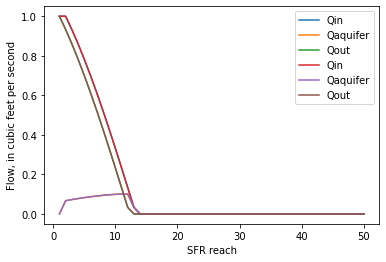

In [11]:
inds = df.segment == 1
#print(df.reach[inds].astype(str))
ax = df.loc[inds, ["reach", "Qin", "Qaquifer", "Qout"]].plot(x="reach")
testdf.loc[inds, ["reach", "Qin", "Qaquifer", "Qout"]].plot(x="reach", ax = ax)
ax.set_ylabel("Flow, in cubic feet per second")
ax.set_xlabel("SFR reach");

## read in outputs

In [10]:
#modelname = "ScenarioSfr2500_2"
headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
budgobj = flopy.utils.binaryfile.CellBudgetFile(modws+'/'+modelname+'.cbc')

head = headobj.get_alldata(nodata=-9.9998999e+02)
#leakage = budgobj.get_data(text='RIVER LEAKAGE')



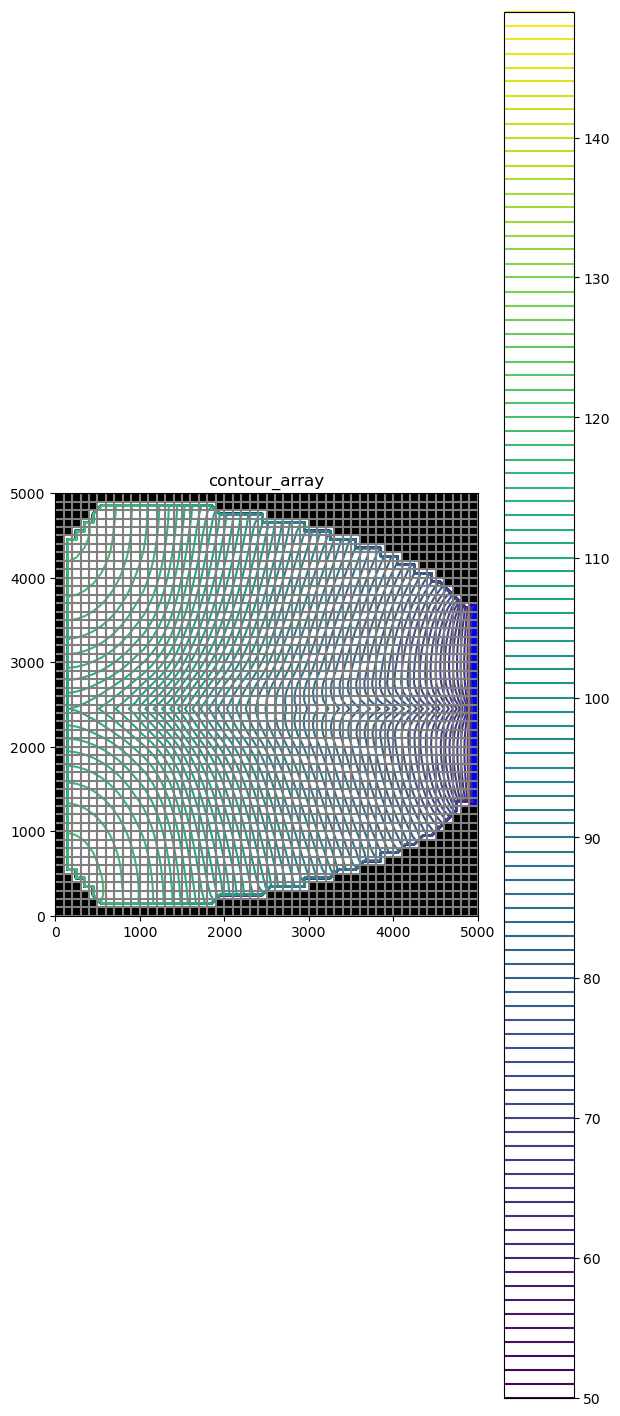

In [49]:
#fname = os.path.join(modelpth, "freyberg.hds")
modelname = "ScenarioSfrWell750Test_"+str(748)

fname = modws+'/'+modelname+'.hds'
hdobj = flopy.utils.HeadFile(fname)
head = hdobj.get_data()
levels = np.arange(50, 150, 1)

fig = plt.figure(figsize=(15, 18))

#ax = fig.add_subplot(1, 2, 1, aspect="equal")
# ax.set_title("plot_array")
# mapview = flopy.plot.PlotMapView(model=m)
# quadmesh = mapview.plot_ibound()
# quadmesh = mapview.plot_array(head, masked_values=[999.0], alpha=0.5)
# #mapview.plot_bc("WEL")
# linecollection = mapview.plot_grid()

ax = fig.add_subplot(1, 2, 2, aspect="equal")
ax.set_title("contour_array")
mapview = flopy.plot.PlotMapView(model=m)
quadmesh = mapview.plot_ibound()
mapview.plot_bc("WEL")
contour_set = mapview.contour_array(head[0], masked_values=[999.0], levels=levels)
fig.colorbar(contour_set, ax=ax)
linecollection = mapview.plot_grid();

## Plots to make sure heads are okie dokie

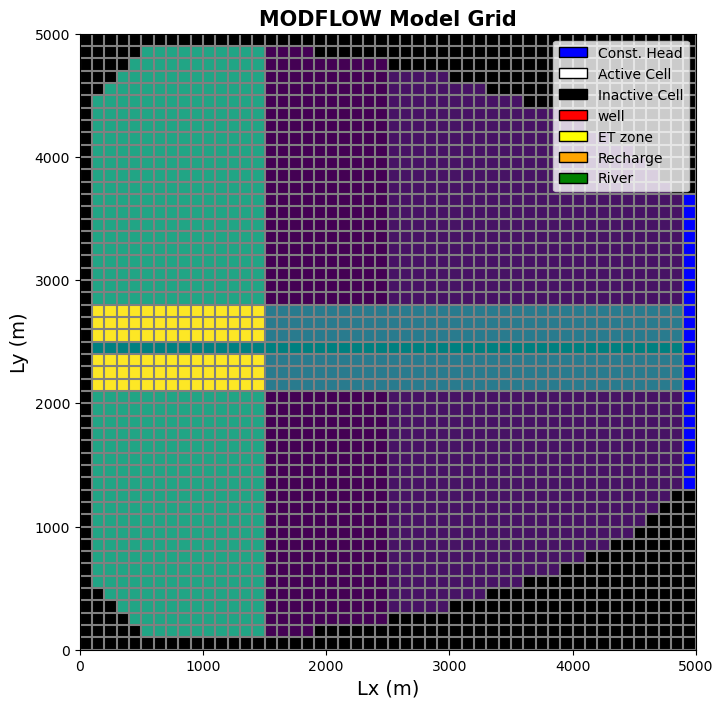

<Figure size 640x480 with 0 Axes>

In [50]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m)
grid = modelmap.plot_grid()
zones = ET_zone + rech_zone_forced
quadmesh = modelmap.plot_array(zones)
# quadmesh = modelmap.plot_array(rech_zone_forced)
# quadmesh = modelmap.plot_array(Rip_zone)

#quadmesh = modelmap.plot_array(rech_zone_forced) #, color='purple')
riv_plot = modelmap.plot_bc(ftype='SFR')
#chd_plot = modelmap.plot_bc(ftype='CHD')
#quadmesh = modelmap.plot_bc(ftype='RCH')
#quadmesh = modelmap.plot_array(win_sq_array)
quadmesh = modelmap.plot_bc('WEL')
quadmesh = modelmap.plot_ibound(ibound)



#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('MODFLOW Model Grid', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                   mp.patches.Patch(color='red',label='well',ec='black'), 
                   mp.patches.Patch(color='yellow',label='ET zone',ec='black'),
                    mp.patches.Patch(color='orange',label='Recharge',ec='black'),
                    mp.patches.Patch(color='green',label='River',ec='black')
                   ])

plt.show(modelmap)
plt.savefig('DomaingridNew.png')

C:\Users\davem\anaconda3\lib\site-packages\flopy\plot\map.py:1272: DeprecationWarning: ModelMap is deprecated and has been replaced by PlotMapView(). ModelMap will be removed in version 3.3.5; Calling PlotMapView()
  warnings.warn(err_msg, DeprecationWarning)


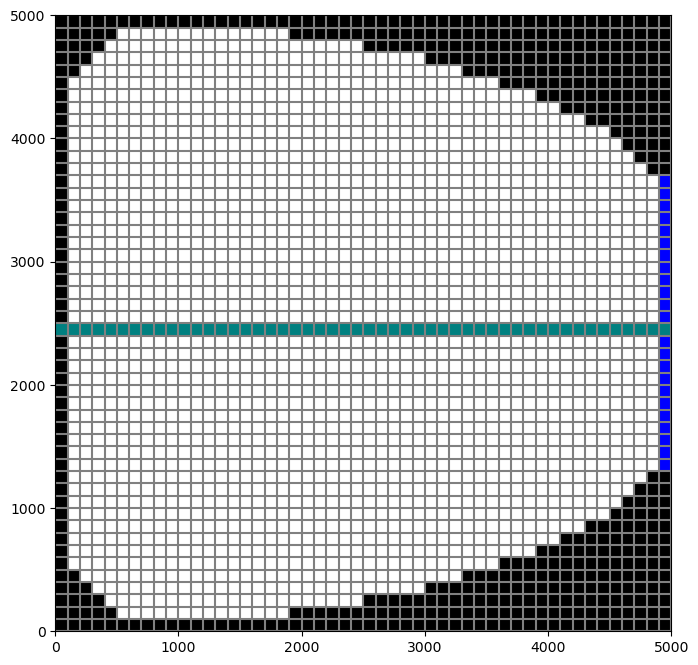

In [51]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=m)
quadmesh = modelmap.plot_ibound()
riv_plot = modelmap.plot_bc('SFR')
quadmesh = modelmap.plot_bc('WEL')
linecollection = modelmap.plot_grid()

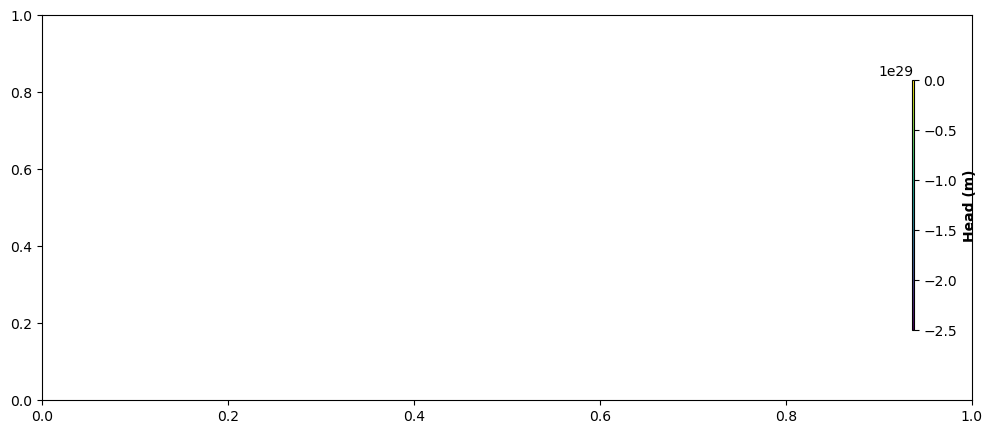

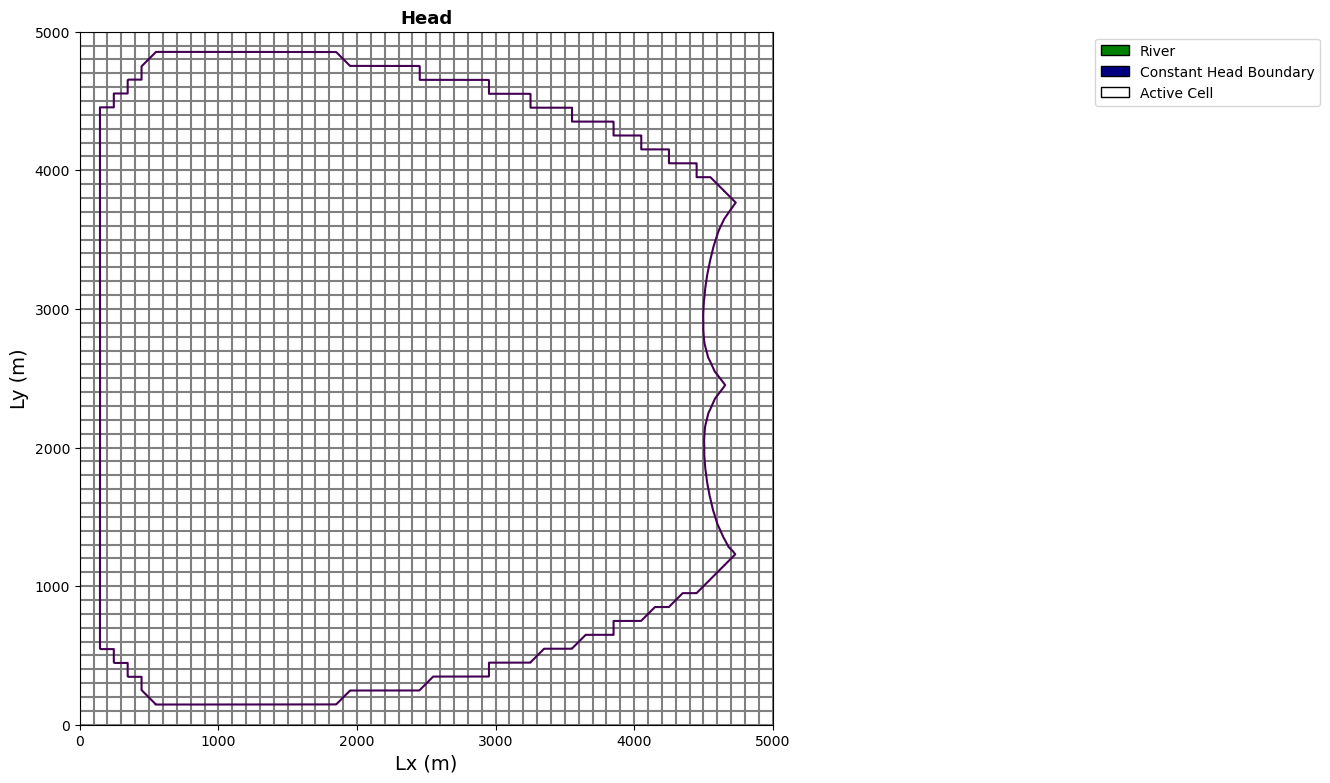

In [52]:
#import 3d axes toolkit from matplotlib
from mpl_toolkits.mplot3d import Axes3D

#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
#ax = fig_3d.gca()
ax = Axes3D(fig_3d)
#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
#Z = np.flipud(head[0])
Z = head[2]
#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=150).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')
plt.show(surf)

plt.figure(figsize=(9,9)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
grid = modelmap.plot_grid() #plot model grid
#riv_plot = modelmap.plot_bc(ftype='RIV') #plot river cells
#chd_plot = modelmap.plot_bc(ftype='CHD') #plot ghb cells
contour_levels = np.linspace(70,95,1) #set contour levels for contouring head
head_contours = modelmap.contour_array(head[0], masked_values=[-1.0000000e+30], levels=contour_levels) #create head contours
#flows = modelmap.plot_discharge(frf['sp%s'%i][0], fff['sp%s'%i][0], head=head['sp%s'%i]) #create discharge arrows
#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Head', fontsize = 13, fontweight = 'bold')
#plt.colorbar(head_contours)
plt.legend(handles=[mp.patches.Patch(color='green',label='River',ec='black'), 
                   mp.patches.Patch(color='navy',label='Constant Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0)) #create legend
plt.show(modelmap)

C:\Users\davem\anaconda3\lib\site-packages\flopy\plot\crosssection.py:1693: MatplotlibDeprecationWarning: Passing the match_original parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patches = PatchCollection(rectcol, match_original, **kwargs)


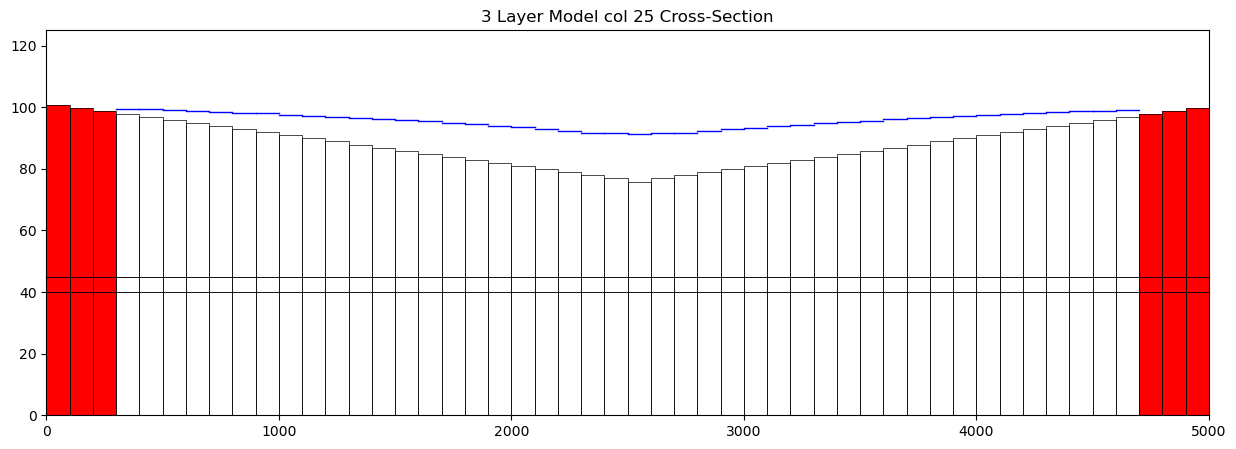

In [54]:

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'column': 25}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='green')
# t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')
headpc = head[0]
#pc = xsect.plot_array(headpc,head=headpc, alpha=0.5)
#patches = xsect.plot_ibound(head=head[0][0])
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model col 25 Cross-Section')
#cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head[0], color='blue', lw=1)

#print(head[0][0][1][:])

C:\Users\davem\anaconda3\lib\site-packages\flopy\plot\crosssection.py:1693: MatplotlibDeprecationWarning: Passing the match_original parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patches = PatchCollection(rectcol, match_original, **kwargs)


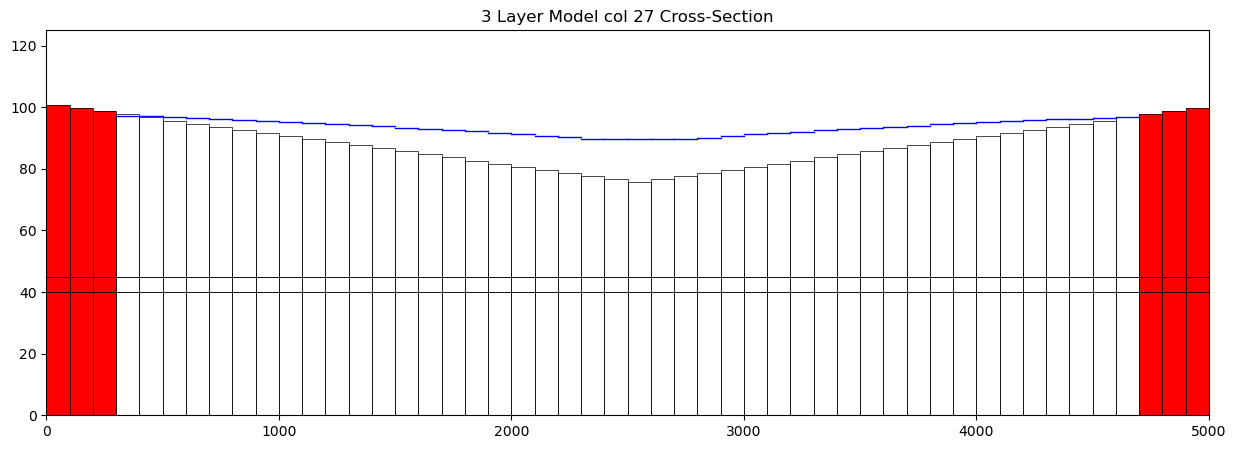

In [55]:

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'column': 27}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='green')
# t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')
headpc = head[0]
#pc = xsect.plot_array(headpc,head=headpc, alpha=0.5)
#patches = xsect.plot_ibound(head=head[0][0])
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model col 27 Cross-Section')
#cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head[0], color='blue', lw=1)

#print(head[0][0][1][:])

C:\Users\davem\anaconda3\lib\site-packages\flopy\plot\crosssection.py:1693: MatplotlibDeprecationWarning: Passing the match_original parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patches = PatchCollection(rectcol, match_original, **kwargs)


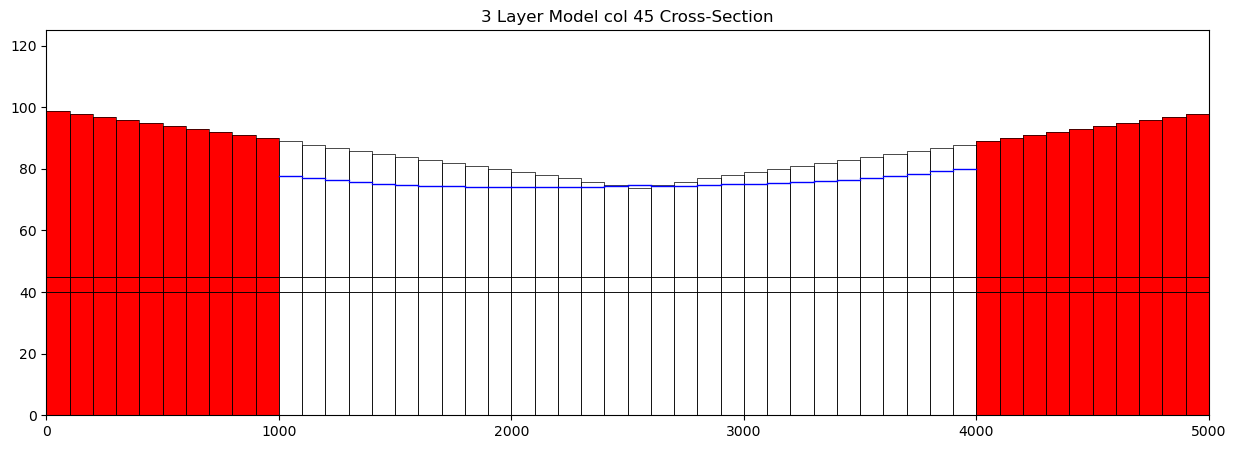

In [47]:

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'column': 45}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='green')
# t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')
headpc = head[0]
#pc = xsect.plot_array(headpc,head=headpc, alpha=0.5)
#patches = xsect.plot_ibound(head=head[0][0])
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model col 45 Cross-Section')
#cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head[0], color='blue', lw=1)

#print(head[0][0][1][:])

## Head at wells

In [30]:
type(head)
head.shape
#print(head[0][0][well_loc[1]][well_loc[2]])
print(len(head[0][0]))

print(head[0][0][int(well_row)][int(well_col)])
print(head[0][0][int(well2_row)][int(well2_col)])
print(head[0][0][int(well3_row)][int(well3_col)])
print(head[0][0][int(well4_row)][int(well4_col)])

50
70.3884
72.17913
75.69171
75.51873


C:\Users\davem\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
